# Автоматическая классификация вида бытового мусора по изображению

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageStat, ImageEnhance
import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import random
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

## Загрузка данных

### Функция для загрузки датасета

In [ ]:
# Функция для загрузки датасета в формате parquet
def get_df_from_hf_parquet(base_url: str, parquet_count: int) -> pd.DataFrame:
  urls = [base_url + f"{i:04}.parquet" for i in range(0, parquet_count)]
  return pd.concat([pd.read_parquet(url) for url in urls])

### Загрузка улучшенного trashnet

In [ ]:
enhanced_url = "https://huggingface.co/datasets/edwinpalegre/trashnet_enhanced/resolve/refs%2Fconvert%2Fparquet/default/train/"

df_enhanced = get_df_from_hf_parquet(enhanced_url, 100)

## Предварительная обработка данных

Выводим количество классов у датасета

In [ ]:
df_enhanced['label'].value_counts()

label
2    4902
0    3692
4    3485
1    2782
3    2484
5    2410
6     137
Name: count, dtype: int64

In [ ]:
df_enhanced = df_enhanced[df_enhanced['label'] != 6]

Можно заметить, что у 6 класса количество данных сильно меньше, чем у остальных. Делаем вывод, что модель не сумеет достаточно обучиться и метрики из-за этого будут хуже. Также этот класс довольно обобщенный. Поэтому убираем 6 класс, не будем его учитывать при обучении

In [ ]:
df_enhanced['label'].value_counts()

label
2    4902
0    3692
4    3485
1    2782
3    2484
5    2410
Name: count, dtype: int64

Убрали 6 класс, теперь в датасете будут только классы с 0 по 5

### Функция для преобразования байтов изображения в массив numpy

Функция преобразует байты изображения в объект PIL.Image с помощью io.BytesIO для чтения байтового представления изображения, а также приводит изображения к размеру (224, 224). Данная функция возвращает нормализованный массив numpy размером (224, 224, 3), готовый для подачи в нейросеть.

In [ ]:
# Функция для преобразования байтов изображения в массив numpy
def bytes_to_array(image_bytes):
    img = Image.open(io.BytesIO(image_bytes['bytes']))
    img = img.resize((224, 224))  # Изменение размера до входного размера MobileNetV2
    img_array = img_to_array(img) / 255.0  # Нормализация значений пикселей
    return img_array

### Аугментация данных для балансировки данных

Аугментация данных — это процесс искусственного увеличения объёма обучающего набора данных путём создания его модифицированных копий.

Если количество примеров меньше max_count, то будем создавать дополнительные аугментированные изображения, чтобы выровнять количество примеров. Затем проводим аугментацию изображений и результат сохраняем в байтовом формате. В результате получаем массив объединенных оригинальных и аугментированных данных (df_balanced), где все классы содержат одинаковое количество примеров.

In [ ]:
# Вычисление максимального количество классов
max_count = df_enhanced['label'].value_counts().max()

balanced_dfs = []

for label in df_enhanced['label'].unique():
    # Извлечение подмножества данных для текущего класса
    class_df = df_enhanced[df_enhanced['label'] == label].copy()
    current_count = len(class_df)

    if current_count < max_count:
        num_needed = max_count - current_count
        augmented_rows = []

        for _ in range(num_needed):
            # Случайным образом выбрать образец из текущего класса
            sample = class_df.sample(n=1).iloc[0]
            img_bytes = sample['image']['bytes']

            # Применение аугментации
            img = Image.open(io.BytesIO(img_bytes))

            # Случайное вращение на угол от -30 до 30 градусов
            angle = random.uniform(-30, 30)
            img = img.rotate(angle, resample=Image.BILINEAR, expand=False)

            # Случайное горизонтальное переворачивание с вероятностью 50%
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)

            # Случайная настройка яркости
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(0.7, 1.3))

            # Случайная настройка контрастности
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(random.uniform(0.7, 1.3))

            # Сохранить аугментированное изображение в байты
            img_byte_arr = io.BytesIO()
            img.save(img_byte_arr, format='JPEG')  # Отрегулировать формат при необходимости
            img_bytes_augmented = img_byte_arr.getvalue()

            # Создать новый образец с аугментированным изображением
            new_sample = sample.copy()
            new_sample['image'] = {'bytes': img_bytes_augmented}
            augmented_rows.append(new_sample)

        # Создание DataFrame для аугментированных образцов
        augmented_df = pd.DataFrame(augmented_rows)
        # Объединение оригинальных и аугментированных образцов для этого класса
        balanced_class_df = pd.concat([class_df, augmented_df], ignore_index=True)
        balanced_dfs.append(balanced_class_df)
    else:
        # Аугментация не нужна; добавить данные оригинального класса
        balanced_dfs.append(class_df)

# Объединение всех классов в сбалансированный DataFrame
df_balanced = pd.concat(balanced_dfs, ignore_index=True)

# Проверка количества сбалансированных классов
print(df_balanced['label'].value_counts())

label
0    4902
1    4902
2    4902
3    4902
4    4902
5    4902
Name: count, dtype: int64


In [ ]:
df_balanced['label'].value_counts()

label
0    4902
1    4902
2    4902
3    4902
4    4902
5    4902
Name: count, dtype: int64

**Вывод:** благодаря аугментации данных мы увеличили объем обучающего набора данных путем создания модифицированных копий, таким образом улучшили обобщающую способность модели и снизили вероятность переобучения. В результате был получен сбалансированный датасет.

## Создание генератора данных

### Пользовательский генератор данных

Данная функция принимает DataFrame (df) с изображениями и метками, а также размер батча (batch_size). Затем в бесконечном цикле (while True) разбивает данные на батчи фиксированного размера. После для каждого батча извлекает изображения и применяет функцию bytes_to_array (преобразует байты в нормализованные numpy-массивы)

In [ ]:
# Пользовательский генератор данных
def data_generator(df, batch_size=32):
    num_samples = len(df)
    while True:  # Бесконечный цикл для обучения
        for offset in range(0, num_samples, batch_size):
            batch_samples = df.iloc[offset:offset + batch_size]
            X = np.array([bytes_to_array(img) for img in batch_samples['image']])
            y = batch_samples['label'].values
            y = to_categorical(y, num_classes=6)  # One-hot кодирование меток
            yield X, y

Таким образом мы подготовили данные перед подачей в нейросеть при обучении:

• Нейросети обучаются на мини-батчах, а не на всем датасете сразу - это усокряет обучение и уменьшает потребление памяти.

• В глубоких нейросетях часто используют генераторы данных, которые бесконечно создают батчи и передают их в модель. Это позволяет не загружать весь датасет в память, а обрабатывать его по частям во время обучения.

### Разделение на обучающую и валидационную выборки

Разделяем данные с помощью train_test_split для сбалансированного датасета (df_balanced) на:

1. Обучающую выборку (train_df, 80% данных).
2. Валидационную выборку (val_df, 20% данных).

Инициализируем генераторы для обучения (train_generator) и валидации (val_generator), используя функцию data_generator.

In [ ]:
# Разделение данных на обучающую и валидационную выборки
train_df, val_df = train_test_split(df_balanced, test_size=0.2, random_state=42)

# Определение размера batch
batch_size = 32

# Создание генераторов для обучения и валидации
train_generator = data_generator(train_df, batch_size=batch_size)
val_generator = data_generator(val_df, batch_size=batch_size)

Определяем количество шагов (итераций) за одну эпоху при обучении и валидации модели в нейросетях.

In [ ]:
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

## Работа с моделью

### Построение модели

Создание модели для классификации изображений на основе MobileNetV2, значительно сэкономит время и вычислительные ресурсы.

In [ ]:
# Загрузка мобильной сетки V2 предварительно отягощенными грузами, исключая верхние слои
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Заморозка слоев базовой модели
base_model.trainable = False

# Добавление пользовательских слоев поверх Mobile Net V2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

# Объединяем базовую модель и пользовательские слои
model = Model(inputs=base_model.input, outputs=predictions)

# Сборка модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Обучение модели

Запуск обучения модели, с помощью генераторов train_generator и val_generator для подачи данных, обучение модели на 10 эпохах (или меньше, если сработает EarlyStopping) и сохранение истории обучения в переменную history.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Мониторим потери на валидационных данных
    patience=3,          # Ждем 3 эпохи без улучшений
    restore_best_weights=True  # Восстанавливаем веса лучшей модели
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 1714s 2s/step - accuracy: 0.8066 - loss: 0.5471 - val_accuracy: 0.9032 - val_loss: 0.2821
Epoch 2/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 1284s 2s/step - accuracy: 0.9221 - loss: 0.2185 - val_accuracy: 0.9107 - val_loss: 0.2687
Epoch 3/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 2617s 4s/step - accuracy: 0.9587 - loss: 0.1188 - val_accuracy: 0.9151 - val_loss: 0.2785
Epoch 4/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 1286s 2s/step - accuracy: 0.9697 - loss: 0.0856 - val_accuracy: 0.9019 - val_loss: 0.3490
Epoch 5/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 1424s 2s/step - accuracy: 0.9776 - loss: 0.0654 - val_accuracy: 0.9332 - val_loss: 0.2537
Epoch 6/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 1471s 2s/step - accuracy: 0.9845 - loss: 0.0480 - val_accuracy: 0.9275 - val_loss: 0.3038
Epoch 7/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 1454s 2s/step - accuracy: 0.9856 - loss: 0.0395 - val_accuracy: 0.9277 - val_loss: 0.3130
Epoch 8/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 1379s 2s/step - accuracy: 0.9870 - loss: 0.0418 - 

**Вывод:**
1. Точность на тренировочных данных (accuracy) значительно увеличилась: с 80.66% (эпоха 1) до 98.73% (эпоха 10).

2. Потери (loss) на обучающем наборе уменьшились: с 0.5471 до 0.0398, что указывает на хорошее обучение модели.


С использованием балансировки данных:
1. Увеличилось число шагов на эпоху:

После балансировки steps_per_epoch увеличилось с 493 до 735, что означает, что модель теперь обрабатывает больше данных за одну эпоху.

Это связано с тем, что исходные данные были несбалансированными, и некоторые классы были представлены слабо, из-за чего модель могла видеть меньше примеров за эпоху.

2. Причина изменения:

После балансировки все классы имеют одинаковое количество примеров, поэтому загрузчик данных может использовать полный датасет без пропусков, увеличивая общее число шагов.

3. Влияние на обучение модели:

* Теперь модель видит больше примеров за эпоху, что может улучшить обучение, так как данные лучше распределены.

* Увеличение steps_per_epoch замедлило обучение, так как на каждую эпоху тратится больше времени.

### Оценка модели

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator, steps=validation_steps)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

183/183 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.9444 - loss: 0.2420
Validation Loss: 0.23192273080348969
Validation Accuracy: 0.9473594427108765


**Вывод:**
1. Точность на обучающем наборе (accuracy): 94.44%. Точность на валидации (Validation Accuracy): 94.74%

2. Обучающие потери (loss): 0.2420. Валидационные потери (Validation Loss): 0.2319. val_loss чуть меньше, чем loss, что говорит о том, что модель не переобучилась.

3. Модель показывает хорошие результаты и не переобучилась. Разница между loss и val_loss небольшая, что говорит о хорошей устойчивости.

Таким образом с использованием аугментации данных точность модели возросла.

Указываем названия классов: биоразлагаемые отходы, картон, стекло, металл, бумага, пластик

In [ ]:
label_mapping_enhanced = {
    0: "BIODEGRADABLE",
    1: "CARDBOARD",
    2: "GLASS",
    3: "METAL",
    4: "PAPER",
    5: "PLASTIC",
}

Использование обученной модели для предсказания классов на валидационных данных. Выполнение построения таких метрик как: матрица ошибок и отчет о классификации.

In [ ]:
# Генерация предсказаний
predictions = model.predict(val_generator, steps=validation_steps)
predicted_classes = np.argmax(predictions, axis=1)

# --- Исправление размеров true_labels ---
true_labels = []
for _ in range(validation_steps):
    _, y_batch = next(val_generator)
    true_labels.extend(np.argmax(y_batch, axis=1))

true_labels = np.array(true_labels)[:len(predicted_classes)]

print(f"Размер true_labels: {len(true_labels)}")
print(f"Размер predicted_classes: {len(predicted_classes)}")

# --- Исправление KerasTensor ---
import tensorflow as tf
if isinstance(predictions, tf.Tensor):
    predictions = predictions.numpy()

# --- Продолжаем построение метрик ---
from sklearn.metrics import confusion_matrix, classification_report

# --- Построение матрицы ошибок и отчета классификации ---
conf_matrix = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(true_labels, predicted_classes)
print("Classification Report:")
print(class_report)


183/183 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step
Размер true_labels: 5851
Размер predicted_classes: 5851
Confusion Matrix:
[[915   1  12   1   2   1]
 [  4 908   6   8  47   7]
 [  4   2 934  21   3  28]
 [  0   1  11 976  11  21]
 [  5  20   2  10 913  19]
 [  2   2  28  10  19 897]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       932
           1       0.97      0.93      0.95       980
           2       0.94      0.94      0.94       992
           3       0.95      0.96      0.95      1020
           4       0.92      0.94      0.93       969
           5       0.92      0.94      0.93       958

    accuracy                           0.95      5851
   macro avg       0.95      0.95      0.95      5851
weighted avg       0.95      0.95      0.95      5851



**Вывод:**
1. Модель демонстрирует высокую эффективность в классификации изображений:
  * Модель достигла accuracy = 0.95 (95%), что свидетельствует о её хорошей способности корректно классифицировать объекты и является высоким результатом.

  * Значения precision, recall и F1-score для всех классов находятся в диапазоне 0.92–0.98, что говорит о сбалансированности модели и отсутствии сильного перекоса в сторону какого-либо класса.

2. Анализ по классам с помощью Confusion Matrix:

* Класс BIODEGRADABLE (0) показал наилучшие результаты (precision = 0.98, recall = 0.98, f1-score = 0.98),что говорит о почти без ошибочном распозновании данного класса моделью.

* Остальные классы также демонстрируют высокие показатели (F1-score 0.93–0.95), но с небольшими вариациями:

  * Класс CADRBOARD (1): Небольшая путаница с классом PAPER (4) (47 ошибок), что может указывать на схожесть их признаков, таких как текстура, цвет и тд.

  * Класс GLASS (2): Основные ошибки связаны с классами METAL (3) и PLASTIC (5) (21 и 28 примеров), возникают, из-за частичного перекрытия признаков.


### Визуализация матрицы ошибок

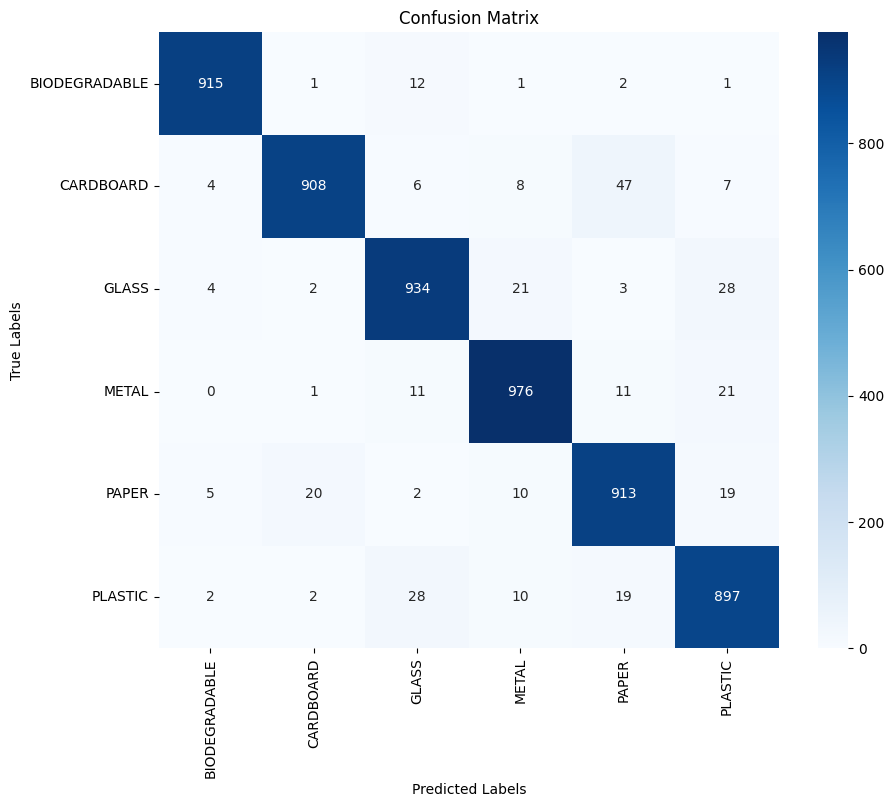

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping_enhanced.values(), yticklabels=label_mapping_enhanced.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Вывод**

Наибольшие ошибки наблюдаются при классификации следующих пар классов:

* PAPER и CARDBOARD (47 объектов из класса PAPER ошибочно отнесли к классу CARDBOARD) - ошибки могут быть связаны со схожестью материалов,

* PLASTIC и GLASS (28 объектов из класса PLASTIC ошибочно отнесли к классу GLASS) - ошибки могут быть связаны с прозрачностью объектов обоих классов.

* GLASS и METAL (21 объект из класса GLASS ошибочно отнесли к классу METAL) - ошибки возможны, из-за отражений и блеска поверхности.

Сравнение результатов до и после балансировки данных
1. Общие показатели:
* До балансировки (3919) - accuracy = 0.93,	после балансировки (5851)	- accuracy = 0.95
* До балансировки (3919) - F1-score = 0.93,	после балансировки (5851)	- F1-score = 0.95

После балансировки общая точность и F1-score улучшились, что подтверждает её положительное влияние на модель.

2. Анализ по классам:

* Все классы стали более сбалансированными (F1-score 0.93–0.98).
* Recall улучшился для проблемных классов (например, класс PAPER (4): с 0.88 до 0.94).
* Confusion Matrix: Ошибки сократились, но остались между теми же классами (PAPER-CARDBOARD, PLASTIC-GLASS и METAL-GLASS).

Балансировка уменьшила дисбаланс в качестве предсказаний, особенно для классов, которые ранее были в меньшинстве.


### Анализ AUC-ROC

AUC (Area Under the Curve) — это метрика качества бинарных классификаторов, измеряющая разделяющую способность модели. Чем ближе AUC к 1.0, тем лучше модель различает классы.

In [ ]:
# Преобразуем метки в бинарный формат
y_bin = label_binarize(true_labels, classes=[0, 1, 2, 3, 4, 5])

# Строим ROC-кривую для каждого класса
for i in range(y_bin.shape[1]):  # Перебираем классы
    fpr, tpr, _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"Класс {i}: AUC = {roc_auc}")


Класс 0: AUC = 0.9996010477023926
Класс 1: AUC = 0.9968426212611917
Класс 2: AUC = 0.9961527992617624
Класс 3: AUC = 0.997118690158738
Класс 4: AUC = 0.9941381304672627
Класс 5: AUC = 0.9953713007419316


### Построение ROC-кривых для каждого класса

Форма y_bin: (5851, 6)
Форма predictions до исправления: (5851, 6)
Форма predictions после исправления: (5851, 6)


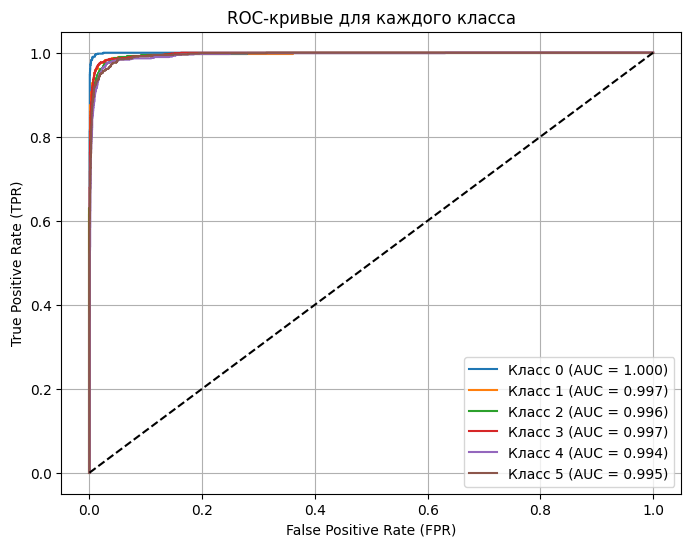

In [ ]:
# Проверяем размеры массивов
print("Форма y_bin:", y_bin.shape)
print("Форма predictions до исправления:", predictions.shape)
print("Форма predictions после исправления:", predictions.shape)

# Построение графика ROC-кривых
plt.figure(figsize=(8, 6))

for i in range(y_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Класс {i} (AUC = {roc_auc:.3f})')

# Добавляем линии и подписи
plt.plot([0, 1], [0, 1], 'k--')  # Линия случайной классификации
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривые для каждого класса')
plt.legend(loc="lower right")
plt.grid()
plt.show()


1. Общая оценка модели:

Значения AUC для всех классов находятся в диапазоне 0.994–0.999, что говорит о высоком качестве работы модели.

2. Сравнительный анализ классов:

  * AUC > 0.99 для каждого класса означает, что модель отлично разделяет положительные и отрицательные примеры.

  * Класс BIODEGRADABLE (0) демонстрирует наилучший результат (AUC ≈ 0.9996), что говорит о почти идеальном разделении.

  * Класс PAPER (4) имеет самый низкий (но всё равно очень высокий) показатель (AUC ≈ 0.994), что может указывать на немного большую сложность в классификации. Такое возможно из-за того что объекты класса PAPER (4) имеет больше пересечений признаков с другими классами такими как CARDBOARD (1) и PLASTIC(5) (например, материал, отражающая поверхность и тд.)

**Вывод:**

Модель достигла почти идеальных значений AUC (0.994–0.999), что означает, что модель очень редко ошибается при классификации. Это подтверждает эффективность выбранной архитектуры и балансировки данных.

## Сохранение модели

In [ ]:
# Сохраняем модель в формате SavedModel
model.export('trash_model')

INFO:tensorflow:Assets written to: trash_model\assets


INFO:tensorflow:Assets written to: trash_model\assets


Saved artifact at 'trash_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2593595577104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2593595577680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2593595579600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2593595579216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2593595578064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2593595579792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2593595578832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2593595577296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2593595579984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2593595577872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2593595580368: TensorSpec(shape=(), dty

## Заключение

**В ходе обучения модели:**
1. Проведена предобработка данных, изображения преобразовывались в numpy-массивы с изменением размера до 224x224 пикселей, а также была реализована аугментация данных для балансировки классов (вращение, отражение, настройка яркости и контрастности).
2. Выполнена балансировка классов (Для классов с недостаточным количеством образцов создавались дополнительные аугментированные версии), в результате которой все классы были приведены к одинаковому количеству образцов.
3. Построена архитектура модели с использованием предобученная MobileNetV2 (без верхних слоев) в качестве базовой модели.
4. Выполнено обучение модели с использованием генератора данных для эффективной работы с большим объемом изображений.
5. Проведена оценка полученных результатов. А именно:

*   Рассчитаны метрики accuracy и loss на валидационной выборке
*   Построена матрица ошибок и отчет классификации
*   Построены ROC-кривые и рассчитаны AUC для каждого класса


---


**В результате:**
1. Модель продемонстрировала высокую эффективность в решении задачи классификации:

  * Accuracy ≈ 98.7% — выдающийся показатель, подтверждающий, что модель правильно предсказывает подавляющее большинство примеров.

  * AUC > 0.99 для всех классов — означает, что модель почти идеально разделяет классы, минимизируя ошибки.

  * Сбалансированные метрики (Precision, Recall, F1-score) — все классы распознаются с высокой точностью (F1-score 0.93–0.98), без значительного перекоса в сторону какого-либо одного класса.

2. Несмотря на отличные результаты, модель испытывает небольшие трудности с некоторыми классами:

  * Классы 1, 4 и 5 имеют чуть более низкий recall (0.88–0.94) по сравнению с другими, что указывает на их частичную схожесть (например, классы 1 и 4 путаются между собой).

  * Матрица ошибок показывает, что основные ошибки связаны с перекрывающимися признаками (например, класс 2 иногда путают с классом 5).

3. Балансировка данных существенно улучшила качество модели:

  * Рост accuracy с 93% до 95% (в сравнении с несбалансированными данными).

  * Улучшение recall для меньшинственных классов (например, класс 5: recall вырос с 0.88 до 0.94).

**Балансировка данных устранила дисбаланс в обучении, позволив модели одинаково хорошо распознавать все классы, а не только доминирующие, что улучшило итоговые результаты.**
  